In [1]:
from mutation import * 
from utility_functions import *
from models import *
import warnings
warnings.filterwarnings("ignore")

2024-08-09 03:47:22.575885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 03:47:22.698200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 03:47:22.727354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 03:47:22.956780: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 03:47:25.846262: W tensorflow/compiler/tf2

In [2]:
folder_path = '/home/fazle/notebook-ws/UCR_TimeSeriesAnomalyDatasets2021/AnomalyDatasets_2021/UCR_TimeSeriesAnomalyDatasets2021/FilesAreInHere/UCR_Anomaly_FullData/'

files = os.listdir(folder_path)

# Filter only .txt files
txt_files = [file for file in files if file.endswith('.txt')]

# Time Series Modeling - Supervised Learning

In [3]:
dataset_seq_wo_mutation = load_data(txt_files, folder_path, mutation_done=False)

Number of matching files: 250
One sample dataframe: 
(       feature
0      -3446.0
1      -3986.0
2      -4527.0
3      -5067.0
4      -5473.0
...        ...
10995  -6418.0
10996  -6554.0
10997  -6689.0
10998  -6824.0
10999  -6824.0

[11000 rows x 1 columns], 2500, 5400, 5600)


5000 11111 11211


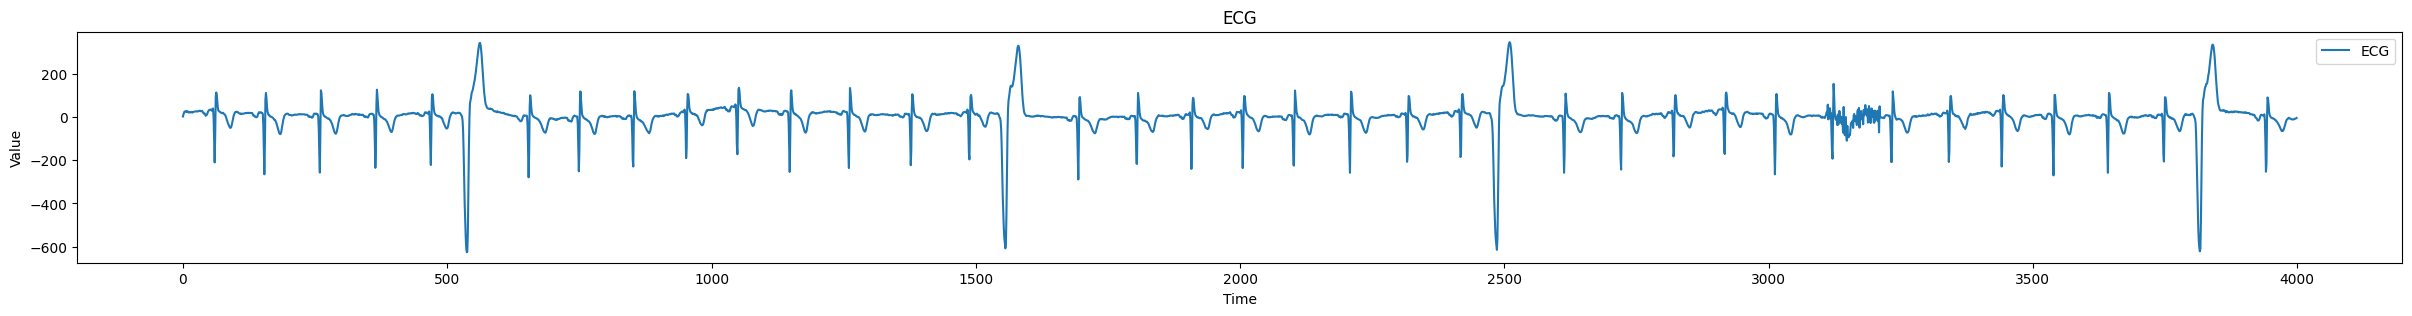

In [23]:
plt.figure(figsize=(30, 3))
plt.plot(dataset_seq_wo_mutation[4][0]['feature'].values[8000:12000], label='ECG')
print(dataset_seq_wo_mutation[4][1], dataset_seq_wo_mutation[4][2], dataset_seq_wo_mutation[4][3])
plt.title('ECG')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
dataset_seq = load_data(txt_files, folder_path, is_record = False, fraction_of_anomaly = 0.05)

In [ ]:
def get_result_for_each_dataset(model, df_tuple, window_size=30, threshold=0.10, cls_weight = 20.0):
    X = df_tuple[0]['feature'].values
    y = df_tuple[0]['is_anomaly'].values
    last_training_data = df_tuple[1]
    begin_anomaly = df_tuple[2]
    end_anomaly = df_tuple[3]

    scaler = MinMaxScaler()
    # X = scaler.fit_transform(X.reshape(-1, 1)).flatten()
    X[:last_training_data] = scaler.fit_transform(X[:last_training_data].reshape(-1, 1)).flatten()
    X[last_training_data:] = scaler.transform(X[last_training_data:].reshape(-1, 1)).flatten()

    # Create sequences - Assuming create_sequences_w_labels returns a 2D array
    X_sequences, y_sequences = create_sequences_w_labels(X, y, window_size)

    # Split into train and test sets
    X_train, X_test = X_sequences[:last_training_data - window_size], X_sequences[last_training_data - window_size:]
    y_train, y_test = y_sequences[:last_training_data - window_size], y_sequences[last_training_data - window_size:]
    class_weights = {0:1.0, 1:cls_weight}
    model.fit(X_train, y_train, epochs=80, verbose=0, batch_size=30, shuffle = False, class_weight = class_weights)
    
    y_pred = model.predict(X_test).flatten()
    correct_or_not = is_prediction_correct((np.argmax(y_pred) + last_training_data), begin_anomaly, end_anomaly)
    y_pred = (y_pred > threshold).astype(int)
    specificity = custom_specificity(y_test, y_pred, tolerance=end_anomaly - begin_anomaly)
    return correct_or_not, specificity
    

In [ ]:
def get_result_for_model(model, dataset_seq, window_size=50, threshold=0.10, cls_weight = 15.0):
    accuracy_scores = []
    specificity_scores = []
        
    for i, df in enumerate(dataset_seq):
        print(f'Training and evaluating on dataset {i+1}')
        accuracy, specificity = get_result_for_each_dataset(model, df, window_size, threshold, cls_weight)
        specificity_scores.append(specificity)
        accuracy_scores.append(accuracy)
        print(f'Dataset {i+1} specificity: {specificity:.4f} Correctly_predicted ------------- {accuracy}')
        
        # Calculate the average precision, recall, and F1 score across all datasets
    average_specificity = np.mean(specificity_scores)
    average_accuracy =  sum(1 for item in accuracy_scores if item == True) / len(accuracy_scores)
    print(f'Average specificity: {average_specificity:.4f} ')
    print(f'Average Accuracy: {average_accuracy:.4f}')
    

**Multi Layer Perceptron-2**

In [ ]:
model = mlp2(window_size = 50)
get_result_for_model(model, dataset_seq, window_size=50, threshold=0.10, cls_weight = 15.0)

**LSTM**

In [ ]:
model = lstm(window_size = 40)
get_result_for_model(model, dataset_seq, window_size=40, threshold=0.10, cls_weight = 5.0)

**BI-LSTM**

In [ ]:
model = bi_lstm(window_size = 30)
get_result_for_model(model, dataset_seq, window_size=30, threshold=0.10, cls_weight = 15.0)

**Gated Recurrent Unit (GRU)**

In [ ]:
model = gru(window_size = 30)
get_result_for_model(model, dataset_seq, window_size=30, threshold=0.10, cls_weight = 15.0)

**Support Vector Machine (SVM2)**

In [ ]:
evaluate_svm(dataset_seq, window_size=100, kernel='rbf')

# Anomalous sequence detection

# semi supervised.

In [ ]:
def train_and_evaluate_seq_models(model, df_tuple, timesteps, segment_length):
    X = df_tuple[0]['feature'].values
    last_training_data = df_tuple[1]
    begin_anomaly = df_tuple[2]
    end_anomaly = df_tuple[3]
    
    train_data, test_data = X[:last_training_data], X[last_training_data:]

    # Create sequences
    train_data = create_sequences_wo_labels(train_data, timesteps)
    test_data = create_sequences_wo_labels(test_data, timesteps)
    
    # Reshape data for LSTM
    train_data = train_data.reshape((train_data.shape[0], timesteps, 1))
    test_data = test_data.reshape((test_data.shape[0], timesteps, 1))
    
    model.fit(train_data, train_data, epochs=70, verbose=0, batch_size=32, shuffle=False)
    
    center_of_anomalous_segment = detect_anomaly(model, test_data, segment_length) + last_training_data
    
    correct = is_prediction_correct(center_of_anomalous_segment, begin_anomaly, end_anomaly)
    return correct

In [ ]:
def evaluate_model (model_c, dataset_seq, time_steps, seg_length):
    results = []
    for i, df in enumerate(dataset_seq):
        print(f'Training and evaluating on dataset {i + 1}')
        correct_or_not = train_and_evaluate_seq_models(model_c, df, time_steps, seg_length)
        results.append(correct_or_not)
        print(f'Dataset {i + 1} correctly identified:--------------- {correct_or_not}')
    
    accuracy = sum(1 for item in results if item == True) / len(results)
    print(f'Final Accuracy: {accuracy}')
    return accuracy

In [ ]:
# 30 & 30 works best for LSTM Autoencoder among all the numbers I have tried.
timesteps = 30
segment_length = 30

**LSTM Autoencoder**

In [ ]:
model = create_lstm_autoencoder((timesteps, 1))
evaluate_model(model, dataset_seq_wo_mutation, timesteps, segment_length)

**Transformer**

In [ ]:
timesteps = 30
segment_length = 30

In [ ]:
model = create_transformer_autoencoder((timesteps, 1))
model.summary()

In [ ]:
evaluate_model(model, dataset_seq_wo_mutation, timesteps, segment_length)

In [ ]:
import optuna

def objective(trial):
    head_size = trial.suggest_int('head_size', 32, 128, step=32)
    num_heads = trial.suggest_int('num_heads', 2, 8, step=2)
    ff_dim = trial.suggest_int('ff_dim', 32, 128, step=32)
    num_transformer_blocks = trial.suggest_int('num_transformer_blocks', 1, 4)
    dropout = trial.suggest_float('dropout', 0.1, 0.5, step=0.1)

    input_shape = (timesteps, 1)
    model = create_transformer_autoencoder(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, dropout)
    
    accuracy = evaluate_model(model, dataset_seq_wo_mutation, timesteps, segment_length)
    
    return -accuracy  # Since Optuna minimizes the objective, use the negative accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


# Time Series Modeling - Statistical Modeling

In [ ]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# The Augmented Dickey-Fuller (ADF) test
for i, df in enumerate(dataset_seq_wo_mutation):
    X = df[0]
    last_training_data = df[1]
    train_data = X[:last_training_data]
    
    result = adfuller(train_data['feature'])
    print(f'ADF Statistic for dataset {i} is : {result[0]}')
    print('p-value:', result[1])
    
    for key, value in result[4].items():
        print('Critical Value {}: {}'.format(key, value))
    print('')

**Autoregressive (AR)**

In [ ]:
def select_ar_model(time_series):
    best_aic = float("inf")
    best_lag = None
    best_model = None

    lags = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 100, 200]
    for l in lags:
        model = AutoReg(time_series['feature'], lags=l).fit()
        aic = model.aic
        if aic < best_aic:
            best_aic = aic
            best_lag = l
            best_model = model

    print(f'best lag for this time series is --------------- {best_lag}')
    return best_lag, best_model

def handle_each_time_series_ar(df_tuple):
    X = df_tuple[0]
    last_training_data = df_tuple[1]
    begin_anomaly = df_tuple[2]
    end_anomaly = df_tuple[3]
    train_data, test_data = X[:last_training_data], X[last_training_data:]
    
    best_lag, model = select_ar_model(train_data)
    predictions = model.predict(start=best_lag, end=len(test_data) - 1, dynamic=False)
    
    # Calculate residuals (actual - predicted)
    residuals = test_data['feature'][best_lag:] - predictions
    anomaly_position = residuals.idxmax()
    correct_or_not = is_prediction_correct(anomaly_position, begin_anomaly, end_anomaly)
    return correct_or_not


def evaluate_statistical_model_ar(dataset_seq):
    results = []
    for i, df in enumerate(dataset_seq):
        print(f'Training and evaluating on dataset {i + 1}')
        correct_or_not = handle_each_time_series_ar(df)
        results.append(correct_or_not)
        print(f'Dataset {i + 1} correctly identified: {correct_or_not}')
    
    accuracy = sum(1 for item in results if item == True) / len(results)
    print(f'Final Accuracy: {accuracy}')
    return accuracy

evaluate_statistical_model_ar(dataset_seq_wo_mutation)

**Moving Average (MA)**

In [ ]:
def handle_each_time_series_ma(df_tuple):
    X = df_tuple[0]
    last_training_data = df_tuple[1]
    begin_anomaly = df_tuple[2]
    end_anomaly = df_tuple[3]
    train_data, test_data = X[:last_training_data], X[last_training_data:]
    window_size = 10 

    moving_average = train_data['feature'].rolling(window=window_size).mean()
    moving_average = moving_average.dropna()

    # The moving average will have `window_size - 1` fewer entries, so adjusting accordingly
    predictions_train = moving_average.reset_index(drop=True)
    predictions_train = predictions_train[window_size - 1:]  # Align predictions with the end of the training data

    last_moving_average = moving_average.iloc[-1]
    predictions_test = [last_moving_average] * len(test_data)

    predictions = list(predictions_train) + predictions_test

    actual_values = train_data['feature'][window_size - 1:].tolist() + test_data['feature'].tolist()
    residuals = [actual - predicted for actual, predicted in zip(actual_values, predictions)]

    residuals = residuals[len(predictions_train):]
    anomaly_position = residuals.index(max(residuals)) + len(predictions_train)  # Adjust for alignment

    correct_or_not = is_prediction_correct(anomaly_position, begin_anomaly, end_anomaly)
    return correct_or_not

def evaluate_statistical_model_ma(dataset_seq):
    results = []
    for i, df in enumerate(dataset_seq):
        print(f'Training and evaluating on dataset {i + 1}')
        correct_or_not = handle_each_time_series_ma(df)
        results.append(correct_or_not)
        print(f'Dataset {i + 1} correctly identified: {correct_or_not}')
    
    accuracy = sum(1 for item in results if item == True) / len(results)
    print(f'Final Accuracy: {accuracy}')
    return accuracy

evaluate_statistical_model_ma(dataset_seq_wo_mutation)

**Autoregressive Integrated Moving Average (ARIMA)**

In [ ]:
def select_arima_model(time_series, max_p, max_q):
    best_aic = float("inf")
    best_order = None
    best_model = None

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(time_series, order=(p, 0, q)).fit()
                aic = model.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, 0, q)
                    best_model = model
            except:
                continue
    print(f'best order for this time series: {best_order}')
    return best_order, best_model


def handle_each_time_series_arima(df_tuple):
    X = df_tuple[0]
    last_training_data = df_tuple[1]
    begin_anomaly = df_tuple[2]
    end_anomaly = df_tuple[3]
    train_data, test_data = X[:last_training_data], X[last_training_data:]

    best_order, model = select_arima_model(train_data['feature'], max_p=5, max_q=5)

    # We need to adjust the start and end parameters for predictions
    start = len(train_data)
    end = start + len(test_data) - 1
    predictions = model.predict(start=start, end=end, dynamic=False)

    # Calculate residuals (actual - predicted)
    residuals = test_data['feature'] - predictions
    anomaly_position = residuals.idxmax()
    correct_or_not = is_prediction_correct(anomaly_position, begin_anomaly, end_anomaly)
    return correct_or_not

def evaluate_statistical_model_arima(dataset_seq):
    results = []
    for i, df in enumerate(dataset_seq):
        print(f'Training and evaluating on dataset {i + 1}')
        correct_or_not = handle_each_time_series_arima(df)
        results.append(correct_or_not)
        print(f'Dataset {i + 1} correctly identified: {correct_or_not}')
    
    accuracy = sum(1 for item in results if item == True) / len(results)
    print(f'Final Accuracy: {accuracy}')
    return accuracy

warnings.filterwarnings("ignore")
evaluate_statistical_model_arima(dataset_seq_wo_mutation)


**Holt-Winters (HW)**

In [ ]:
def select_hw_model(time_series):
    best_aic = float("inf")
    best_seasonal_period = None
    best_model = None

    seasonal_periods = [5, 20, 35, 50, 65]
    for period in seasonal_periods:
        try:
            model = ExponentialSmoothing(
                time_series['feature'], 
                seasonal_periods=period, 
                trend='add', 
                seasonal='add'
            ).fit()
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                best_seasonal_period = period
                best_model = model
        except Exception as e:
            print(f"Skipping seasonal period {period} due to error: {e}")
            continue

    print(f'Best seasonal period for this time series is --------------- {best_seasonal_period}')
    return best_seasonal_period, best_model

def handle_each_time_series_hw(df_tuple):
    X = df_tuple[0]
    last_training_data = df_tuple[1]
    begin_anomaly = df_tuple[2]
    end_anomaly = df_tuple[3]
    train_data, test_data = X[:last_training_data], X[last_training_data:]

    best_seasonal_period, model = select_hw_model(train_data)

    # Make predictions
    predictions = model.forecast(steps=len(test_data))

    # Calculate residuals (actual - predicted)
    residuals = test_data['feature'] - predictions
    anomaly_position = residuals.idxmax()
    correct_or_not = is_prediction_correct(anomaly_position, begin_anomaly, end_anomaly)
    return correct_or_not

def evaluate_statistical_model_hw(dataset_seq):
    results = []
    for i, df in enumerate(dataset_seq):
        print(f'Training and evaluating on dataset {i + 1}')
        correct_or_not = handle_each_time_series_hw(df)
        results.append(correct_or_not)
        print(f'Dataset {i + 1} correctly identified: {correct_or_not}')
    
    accuracy = sum(1 for item in results if item) / len(results)
    print(f'Final Accuracy: {accuracy}')
    return accuracy

evaluate_statistical_model_hw(dataset_seq_wo_mutation)


# Time Series Decomposition

In [ ]:
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf

**Seasonal-Trend decomposition using LOESS (STL)**

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf

def estimate_period(time_series):
    autocorr = acf(time_series, nlags=len(time_series)//2)
    period = np.argmax(autocorr[1:]) + 1
    if period < 2:
        period = 2
    return period

def select_stl_model(time_series, period):
    stl = STL(time_series['feature'], period=period, seasonal=3)
    result = stl.fit()
    
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid
    n = len(residual)
    rss = np.sum(residual**2)
    aic = n * np.log(rss / n) + 2 * 2  # 2 for trend and seasonal components
    
    return trend, seasonal, residual, aic

def forecast_stl_components(trend, seasonal, test_length, period):
    if len(trend) == 0 or len(seasonal) == 0:
        raise ValueError("Trend or Seasonal components are empty.")
    
    # Extend the trend by repeating the last value
    trend_forecast = np.append(trend, [trend.iloc[-1]] * test_length)
    
    # Extend the seasonal component by repeating the seasonal pattern
    seasonal_pattern = seasonal[-period:]
    seasonal_forecast = np.tile(seasonal_pattern, (test_length // period) + 1)[:test_length]
    
    return trend_forecast[-test_length:], seasonal_forecast

def handle_each_time_series_stl(df_tuple):
    X = df_tuple[0]
    last_training_data = df_tuple[1]
    begin_anomaly = df_tuple[2]
    end_anomaly = df_tuple[3]
    train_data, test_data = X[:last_training_data], X[last_training_data:]

    # Estimate the period for the current time series
    period = estimate_period(train_data['feature'])
    
    trend, seasonal, residual, aic = select_stl_model(train_data, period)
    
    # Forecast the trend and seasonal components for the test period
    trend_forecast, seasonal_forecast = forecast_stl_components(trend, seasonal, len(test_data), period)
    prediction = trend_forecast + seasonal_forecast
    
    # Calculate residuals (actual - predicted)
    residuals = test_data['feature'].values - prediction
    anomaly_position = residuals.argmax()
    correct_or_not = is_prediction_correct(anomaly_position, begin_anomaly, end_anomaly)
    return correct_or_not

def evaluate_statistical_model_stl(dataset_seq):
    results = []
    for i, df in enumerate(dataset_seq):
        print(f'Training and evaluating on dataset {i + 1}')
        correct_or_not = handle_each_time_series_stl(df)
        results.append(correct_or_not)
        print(f'Dataset {i + 1} correctly identified ------------ {correct_or_not}')
    
    accuracy = sum(1 for item in results if item) / len(results)
    print(f'Final Accuracy: {accuracy}')
    return accuracy

# Example usage with your dataset
evaluate_statistical_model_stl(dataset_seq_wo_mutation)
